In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm
from siffpy import SiffReader
from siffpy.core import utils
%matplotlib widget
import cupy as cp
from napari import Viewer
from scipy.interpolate import interp1d
import h5py as h5


In [2]:
import cupyx

mempool = cp.get_default_memory_pool()

In [3]:
p_img_dset='/mnt/fast/Data_Imaging/img/20240723_fly6/20240723_175107_fly6_1.siff'
sr=SiffReader(p_img_dset)


In [4]:
viewer=Viewer()

In [4]:
vol=sr.get_frames(frames=sr.im_params.flatten_by_timepoints(color_channel=0))
vol=vol.reshape([sr.im_params.array_shape[ii] for ii in [0,1,3,4]])

In [5]:
from cupyx.scipy.ndimage import gaussian_filter


def free_gpu_memory(func):
    def wrapper_func(*args, **kwargs):
        retval = func(*args, **kwargs)
        cp._default_memory_pool.free_all_blocks()
        return retval
    return wrapper_func


@free_gpu_memory
def general_phase_correlation(img1, img2, eps=1e-8,max_shift=100):
    # Convert images to frequency domain
    img2_fft = cp.fft.fft2(img2)
    img1_fft = cp.fft.fft2(img1)
    cross_power_spectrum = (img1_fft * cp.conj(img2_fft)) / (cp.abs(img1_fft * cp.conj(img2_fft)) + eps)
    cross_correlation = cp.fft.ifft2(cross_power_spectrum)
    max_loc = cp.unravel_index(cp.argmax(cross_correlation), cross_correlation.shape)
    shift=cp.array(max_loc)-cp.array(cross_correlation.shape)/2
    return shift.get(),cross_correlation



@free_gpu_memory
def phase_correlation(img1, img2, eps=1e-8):

    cross_correlation = cupyx.scipy.ndimage.correlate(img1,img2)#cp.fft.ifft2(cross_power_spectrum)

   
    max_loc = cp.unravel_index(cp.argmax(cross_correlation), cross_correlation.shape)
    shift=cp.array(max_loc)-cp.array(cross_correlation.shape)/2
    #del cross_correlation
    return shift.get(),cross_correlation
    
@free_gpu_memory


def shift_image_in_place(img, shift_x, shift_y):
    # Get the image shape
    rows, cols = img.shape

    # Create the meshgrid for frequencies
    row_indices = cp.fft.fftfreq(rows).reshape(-1, 1)
    col_indices = cp.fft.fftfreq(cols).reshape(1, -1)

    # Create the phase shift in the frequency domain
    phase_shift = cp.exp(-2j * cp.pi * (shift_x * row_indices + shift_y * col_indices))

    # Perform the Fourier transform of the image
    img_fft = cp.fft.fft2(img)

    # Apply the phase shift
    img_fft_shifted = img_fft * phase_shift

    # Perform the inverse Fourier transform to get the shifted image
    shifted_img = cp.fft.ifft2(img_fft_shifted).real

    return shifted_img

@free_gpu_memory
def determine_shifts(plane,n_bin,sigma,i_ref):
    pl_c=cp.array(plane,'single')
    n_t=pl_c.shape[0]
    pl_b=pl_c[:(n_t//n_bin)*n_bin].reshape(n_t//n_bin,n_bin,pl_c.shape[1],pl_c.shape[2]).mean(1)
    im_ref=cp.copy(pl_b[i_ref])
    pl_b=gaussian_filter(pl_b,[0,sigma,sigma])
    pl_b-=gaussian_filter(pl_b,[0,3*sigma,3*sigma])
    pl_c_w=(pl_b-pl_b.mean((1,2),keepdims=True))/pl_b.std((1,2),keepdims=True,)
    #im_ref=cp.array(im_ref,'single')
    shifts=[phase_correlation(im_ref,im) for im in tqdm(pl_c_w)]
    return shifts


def shift_recording(vol,shifts,max_shifts):
    ix=(np.abs(shifts)>max_shifts)
    shifts[ix]=0
    for iplane in range(vol.shape[1]):
        for ii in tqdm(range(vol.shape[0])):
            s=shifts[iplane][ii]
            vol[ii,iplane]=np.roll(np.roll(vol[ii,iplane],int(s[0]),axis=0),int(s[1]),axis=1)
            return vol

In [7]:
n_bin=1
sub=20
sigma=3
iplane=4
n_t=vol.shape[0]

In [8]:
plane=vol[:,iplane,:,:]
pl_c=cp.array(plane,'single')
pl_b=cp.copy(pl_c[:(n_t//n_bin)*n_bin].reshape(n_t//n_bin,n_bin,pl_c.shape[1],pl_c.shape[2]).mean(1)[::sub]
del pl_c
#del pl_b
mempool.free_all_blocks()

ref_im=cp.copy(pl_b[pl_b.shape[0]//2])
print(pl_b.shape)

(1950, 256, 128)


In [11]:
import gc

# Synchronize to ensure all operations are done
cp.cuda.Stream.null.synchronize()

# Force garbage collection
gc.collect()
mempool.free_all_blocks()

In [11]:
del pl_b
mempool.free_all_blocks()

NameError: name 'pl_b' is not defined

In [12]:
mempool.free_all_blocks()

In [9]:
sig=1.2
sig_map=2
shift=[0,0]
pl_c=cp.roll(cp.roll(pl_c,shift[0],axis=1),shift[1],axis=2)

pl_c_ft=cp.fft.fft2(gaussian_filter(pl_c,[0,sig,sig]))
ref_ft=cp.fft.fft2(gaussian_filter(im1,[sig,sig]))
eps=200
pl_c_ft/=(cp.abs(pl_c_ft)+eps)
ref_ft/=(cp.abs(ref_ft)+eps)
corr=gaussian_filter(cp.fft.fftshift(cp.abs(cp.fft.ifft2(pl_c_ft*cp.conj(ref_ft))),axes=[1,2]),[0,sig_map,sig_map])

fig,ax=plt.subplots(1,3)
i_im=10
ax[0].imshow(ref_im.get())
ax[1].imshow(pl_c[i_im].get())
ax[2].imshow(corr[i_im].get(),vmax=cp.percentile(corr[0],99.999).get())


viewer.add_image(corr.get())
viewer.add_image(plane)

NameError: name 'im1' is not defined

<Image layer 'Image' at 0x7f29be4d6a40>

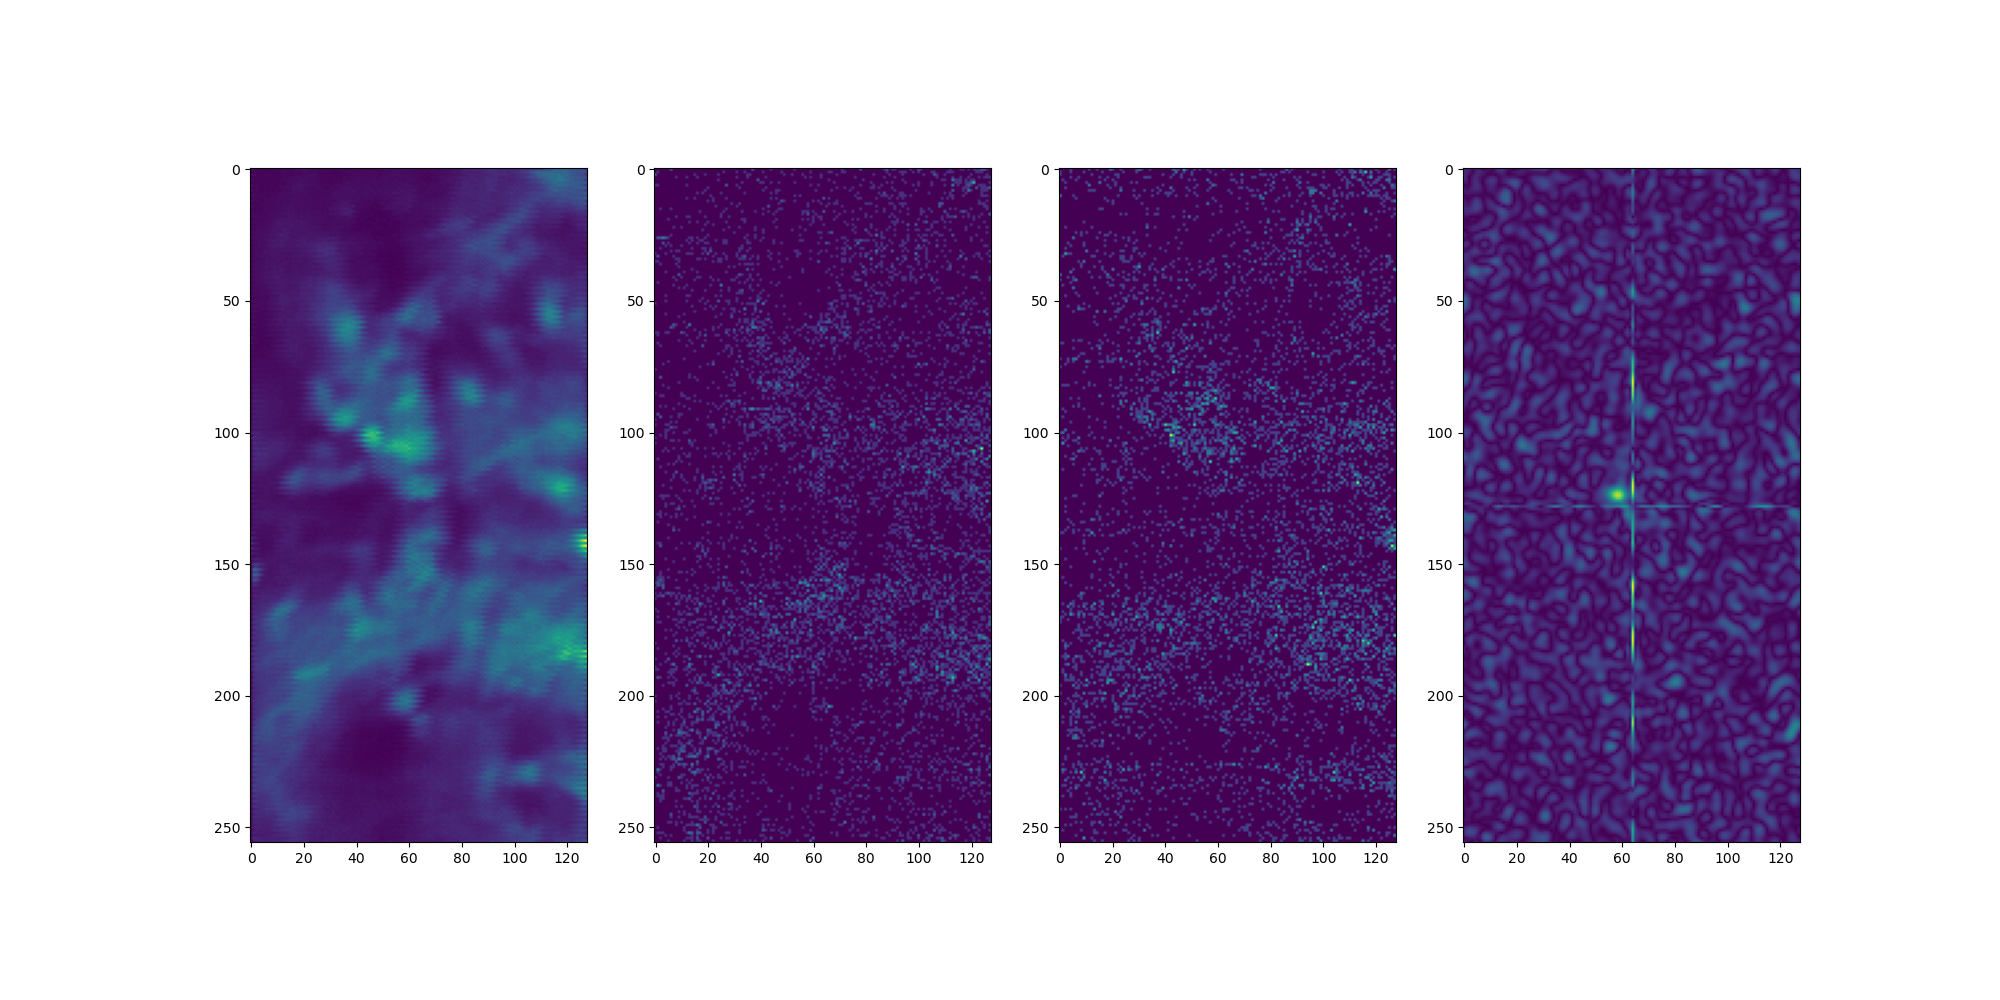

In [148]:
im_1=pl_c[pl_c.shape[0]//2]
shift=[100,40]
#im2=cp.roll(cp.roll(im1,shift[0],axis=0),shift[1],axis=1)
im2=pl_c[pl_c.shape[0]//2+20]
fig,ax=plt.subplots(1,4,figsize=[20,10])
ax[0].imshow(pl_c.mean(0).get())
ax[1].imshow(im1.get())
ax[2].imshow(im2.get())

eps=10
sig=2
im_ft=cp.fft.fft2(gaussian_filter(im2,[sig,sig]))
ref_ft=cp.fft.fft2(gaussian_filter(im1,[sig,sig]))
im_ft/=(cp.abs(im_ft)+eps)
ref_ft/=(cp.abs(ref_ft)+eps)
corr=cp.fft.fftshift(cp.abs(cp.fft.ifft2(im_ft*cp.conj(ref_ft))))



#shft,corr=phase_correlation(im1,im2)
#ax[3].imshow(corr.get())
#shft,corr=general_phase_correlation(im1,im2,eps=0)
ax[3].imshow(cp.abs(corr).get(),)#vmax=cp.percentile(corr[0],99.9999).get())

In [10]:
i_ref=n_t//n_bin//2
im_ref=cp.copy(pl_b[i_ref])

NameError: name 'pl_b' is not defined

In [12]:
sigma=5
sigma2=30
pl_b=pl_c[:(n_t//n_bin)*n_bin].reshape(n_t//n_bin,n_bin,pl_c.shape[1],pl_c.shape[2]).mean(1)
pl_b=gaussian_filter(pl_b,[0,sigma,sigma])
pl_b-=gaussian_filter(pl_b,[0,sigma2,sigma2])

In [14]:
viewer.add_image(pl_b.get())

<Image layer 'Image' at 0x7f8a97f358a0>

In [15]:
def dog(im,sigma0,sigma1):
    im=gaussian_filter(im,[sigma0,sigma0])
    im-=gaussian_filter(im,[sigma1,sigma1])
    return im

In [16]:

im_ref=cp.copy(pl_b[i_ref])
pl_b=gaussian_filter(pl_b,[0,sigma,sigma])
pl_b-=gaussian_filter(pl_b,[0,sigma2,sigma2])
pl_c_w=(pl_b-pl_b.mean((1,2),keepdims=True))/pl_b.std((1,2),keepdims=True,)
#im_ref=cp.array(im_ref,'single')
shifts=[phase_correlation(im_ref,im) for im in tqdm(pl_c_w)]

  0%|          | 0/9750 [00:00<?, ?it/s]

In [17]:
pl_b=gaussian_filter(pl_b,[0,sigma,sigma])
pl_b-=gaussian_filter(pl_b,[0,sigma2,sigma])

OutOfMemoryError: Out of memory allocating 1,277,952,000 bytes (allocated so far: 10,223,747,584 bytes).

In [18]:
s,im=general_phase_correlation(im1,im2)
fig,ax=plt.subplots()
ax.imshow(cp.real(im).get())

NameError: name 'im1' is not defined

In [34]:
np.r_[im1.shape]//2+general_phase_correlation(im1,im2)

array([  2., 123.])

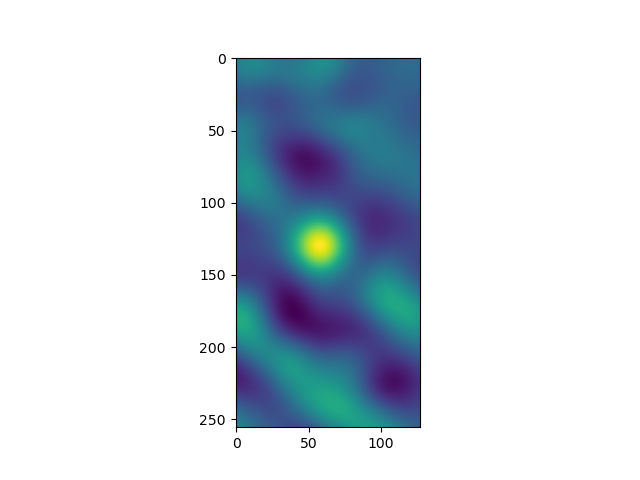

In [44]:
s,im=phase_correlation(im1,im2)
fig,ax=plt.subplots()
ax.imshow(im.get())

In [ ]:
fig,ax=plt.subplots(1,2)
ii=100

im1=dog(pl_b[ii],sigma,sigma2)
ax[0].imshow(im1.get(),cmap='Greens',alpha=0.3)
for jj in tqdm(range(6000,7000)):
    im2=dog(pl_b[jj],sigma,sigma2)
    s=phase_correlation(im1,im2)
    im_shift=cp.roll(cp.roll(im2,int(s[0]),axis=0),int(s[1]),axis=1)
    im1+=im_shift

ax[0].imshow(im2.get(),cmap='Reds',alpha=0.3)
ax[1].imshow(im1.get(),cmap='Greens',alpha=0.3)
ax[1].imshow(im_shift.get(),cmap='Reds',alpha=0.3)

In [ ]:
shifts=[determine_shifts(vol[:,iplane,:,:],n_bin,sigma,n_t//n_bin//2) for iplane in range(vol.shape[1])]

In [ ]:
# 

In [26]:
frames=np.arange(0,n_t,n_bin)
shift_indx=interp1d(frames,np.arange(n_t//n_bin),'nearest',bounds_error=False,fill_value='extrapolate')(np.arange(n_t)).astype('int')
shifts=np.array(shifts)
shifts_all=shifts[:,shift_indx]

In [24]:
p_tmp='/tmp/shifts.h5'
with h5.File(p_tmp,'w') as fh5:
    fh5['shifts']=shifts_all

# Shift

In [8]:
p_tmp='/tmp/shifts.h5'
with h5.File(p_tmp,'r') as fh5:
    shifts_all=fh5['shifts'][:]

In [10]:
# plane_raw=vol[:(n_t//n_bin)*n_bin,iplane,:,:].reshape(n_t//n_bin,n_bin,vol.shape[2],vol.shape[3]).mean(1)
# viewer.add_image(plane_raw,colormap='Green',blending='additive',name='raw_bin')p
#plane_reg=np.zeros_like(plane_raw)
# viewer.add_image(plane_raw.mean(0),colormap='Green',blending='additive')    

# im_ref=vol[n_t//n_bin//2,iplane]
# viewer.add_image(im_ref,colormap='Green',blending='additive')
# viewer.add_image(plane_reg.mean(0),colormap='Magenta',blending='additive')    
# max_shifts=100
# shifts=shifts_all
# ix=(np.abs(shifts)>max_shifts)
# shifts[ix]=0
# for ii in tqdm(range(plane_reg.shape[0])):
#     s=shifts[iplane][ii*n_bin]
#     im=plane_raw[ii]
#     plane_reg[ii]=np.roll(np.roll(im,int(s[0]),axis=0),int(s[1]),axis=1)
# viewer.add_image(plane_reg,colormap='Magenta',blending='additive')    

In [9]:
vol_reg=np.zeros_like(vol)

In [10]:
# for iplane in range(vol.shape[1]):
#     pl=vol[:,iplane].astype('single')
#     cp.cuda.runtime.memcpy(pl_c.data.ptr, pl.ctypes.data, pl.nbytes, cp.cuda.runtime.memcpyHostToDevice)
#     for ii in tqdm(range(pl_c.shape[0])):
#         pl_c[ii]=shift_image_in_place(pl_c[ii],*shifts_all[iplane,ii]])
#     vol_reg[:,iplane]=pl_c.get().astype('uint16')
   
# del pl_c
# mempool.free_all_blocks()
  

In [11]:
max_shifts=20
shifts=shifts_all
ix=(np.abs(shifts)>max_shifts)
shifts[ix]=0
for iplane in range(vol.shape[1]):
    for ii in tqdm(range(vol.shape[0])):
        s=shifts[iplane][ii]
        vol_reg[ii,iplane]=np.roll(np.roll(vol[ii,iplane],int(s[0]),axis=0),int(s[1]),axis=1)

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

  0%|          | 0/36000 [00:00<?, ?it/s]

In [12]:
viewer.add_image(vol_reg,colormap='Magenta',blending='additive')

<Image layer 'vol_reg' at 0x7f747483f490>

In [13]:
vol_reg_b=vol_reg[:(n_t//n_bin)*n_bin].reshape(n_t//n_bin,n_bin,vol_reg.shape[1],vol_reg.shape[2],vol_reg.shape[3]).sum(1)

In [14]:
viewer.add_image(vol_reg_b,colormap='Magenta',blending='additive')    

<Image layer 'vol_reg_b' at 0x7f719cff7460>

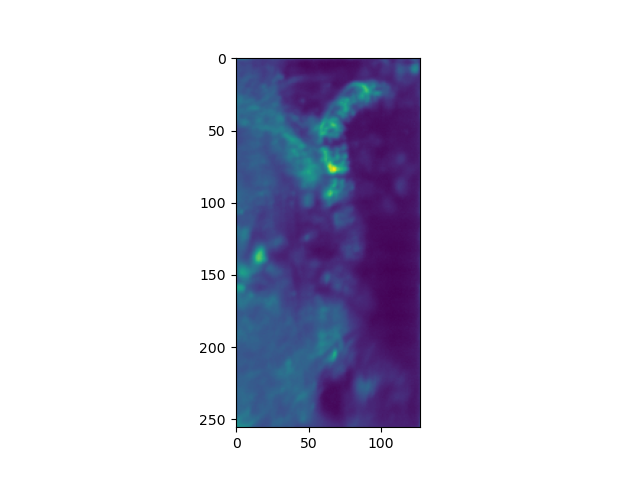

In [21]:
fig,ax=plt.subplots()
ax.imshow(vol_reg_b[:,4].std(0))